In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack

In [27]:
df = pd.read_csv('airlines_reviews.csv') 

cols_to_keep = ['Airline', 'Overall Rating', 'Class', 'Type of Traveller', 
                'Reviews', 'Recommended', 'Seat Comfort', 'Staff Service', 
                'Value For Money']

df = df[cols_to_keep].copy()

df['target'] = df['Recommended'].apply(lambda x: 1 if str(x).lower() == 'yes' else 0)

def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text) 
    return text

df['clean_review'] = df['Reviews'].apply(clean_text)

cols_check_na = ['Class', 'Type of Traveller', 'Seat Comfort', 'Staff Service', 'Value For Money', 'clean_review']
df = df.dropna(subset=cols_check_na)

print(f"Dataset processado e limpo: {df.shape}")

Dataset processado e limpo: (8100, 11)


In [28]:
X = df.drop(columns=['target', 'Recommended', 'Reviews'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = {}

numeric_features = ['Seat Comfort', 'Staff Service', 'Value For Money']
categorical_features = ['Class', 'Type of Traveller']

preprocessor_tab = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

print("\nTreinando Modelo 1: Tabular...")
model_tab = Pipeline(steps=[('preprocessor', preprocessor_tab),
                            ('classifier', LogisticRegression(max_iter=1000))])

model_tab.fit(X_train, y_train)
y_pred_tab = model_tab.predict(X_test)
results['Tabular'] = accuracy_score(y_test, y_pred_tab)

print("Treinando Modelo 2: Textual...")
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_train_text = vectorizer.fit_transform(X_train['clean_review'])
X_test_text = vectorizer.transform(X_test['clean_review'])

model_text = LogisticRegression(max_iter=1000)
model_text.fit(X_train_text, y_train)
y_pred_text = model_text.predict(X_test_text)
results['Textual'] = accuracy_score(y_test, y_pred_text)

print("Treinando Modelo 3: Híbrido...")

X_train_tab_processed = preprocessor_tab.fit_transform(X_train)
X_test_tab_processed = preprocessor_tab.transform(X_test)

X_train_combined = hstack([X_train_tab_processed, X_train_text])
X_test_combined = hstack([X_test_tab_processed, X_test_text])

model_hybrid = LogisticRegression(max_iter=1000)
model_hybrid.fit(X_train_combined, y_train)
y_pred_hybrid = model_hybrid.predict(X_test_combined)
results['Híbrido'] = accuracy_score(y_test, y_pred_hybrid)



Treinando Modelo 1: Tabular...
Treinando Modelo 2: Textual...
Treinando Modelo 3: Híbrido...



--- Tabela de Acurácia ---
         Acurácia
Tabular  0.895062
Textual  0.914815
Híbrido  0.925926


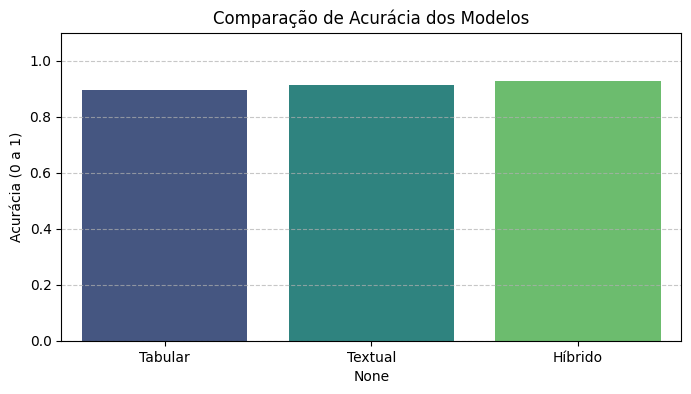


--- Top 20 Palavras para 'Recomenda' (Pesos Positivos) ---
              word    weight
617      excellent  5.705102
769           good  4.550780
772          great  4.015162
731       friendly  3.351911
1771         thank  3.303844
62         amazing  3.292307
365    comfortable  3.185440
187           best  3.097906
814        helpful  2.777474
1298      pleasant  2.732980
479      delicious  2.515241
1356  professional  2.463612
197            bit  2.462988
139      attentive  2.429547
567      efficient  2.385173
1228       overall  2.280545
1719        superb  2.248828
1155          nice  2.243920
1377         qatar  2.136812
1751         tasty  2.081295

--- Top 20 Palavras para 'Não Recomenda' (Pesos Negativos) ---
               word    weight
1981          worst -3.965482
1313           poor -3.650692
1765       terrible -3.368430
1800           told -2.825926
156             bad -2.662517
1508           rude -2.585889
446        customer -2.307449
1980          worse -2.2823

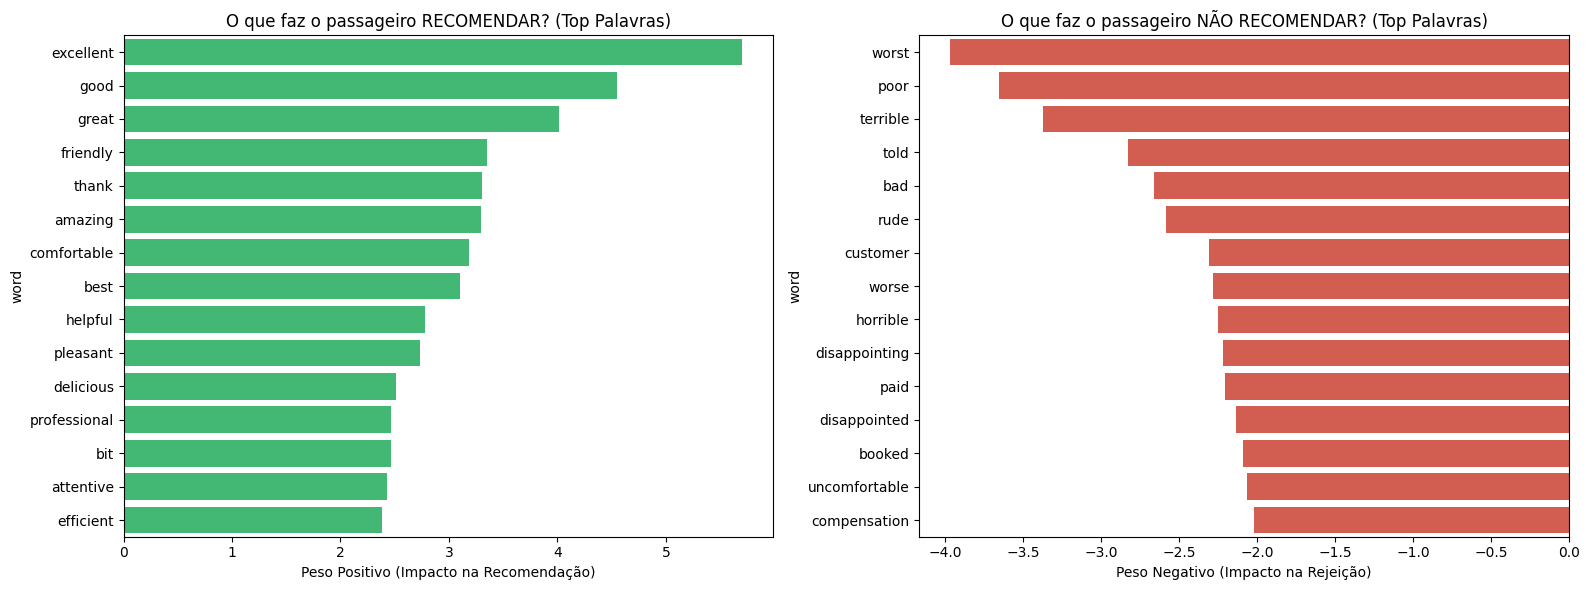


--- Relatório de Classificação (Modelo Híbrido) ---
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       761
           1       0.92      0.94      0.93       859

    accuracy                           0.93      1620
   macro avg       0.93      0.93      0.93      1620
weighted avg       0.93      0.93      0.93      1620



In [29]:
print("\n--- Tabela de Acurácia ---")
df_res = pd.DataFrame.from_dict(results, orient='index', columns=['Acurácia'])
print(df_res)

plt.figure(figsize=(8,4))
sns.barplot(x=df_res.index, y=df_res['Acurácia'], hue=df_res.index, palette='viridis', legend=False)
plt.title("Comparação de Acurácia dos Modelos")
plt.ylim(0, 1.1) 
plt.ylabel("Acurácia (0 a 1)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

feature_names = vectorizer.get_feature_names_out()
coefs = model_text.coef_[0]

word_importance = pd.DataFrame({'word': feature_names, 'weight': coefs})
word_importance = word_importance.sort_values(by='weight', ascending=False)

print("\n--- Top 20 Palavras para 'Recomenda' (Pesos Positivos) ---")
print(word_importance.head(20))

print("\n--- Top 20 Palavras para 'Não Recomenda' (Pesos Negativos) ---")
print(word_importance.tail(20).sort_values(by='weight', ascending=True))

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=word_importance.head(15), x='weight', y='word', ax=ax[0], color='#2ecc71')
ax[0].set_title("O que faz o passageiro RECOMENDAR? (Top Palavras)")
ax[0].set_xlabel("Peso Positivo (Impacto na Recomendação)")

sns.barplot(data=word_importance.tail(15).sort_values(by='weight'), x='weight', y='word', ax=ax[1], color='#e74c3c')
ax[1].set_title("O que faz o passageiro NÃO RECOMENDAR? (Top Palavras)")
ax[1].set_xlabel("Peso Negativo (Impacto na Rejeição)")

plt.tight_layout()
plt.show()

print("\n--- Relatório de Classificação (Modelo Híbrido) ---")
print(classification_report(y_test, y_pred_hybrid))